In [1]:
import numpy as np
import random
import torch

import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

import matplotlib.pyplot as plt 
import matplotlib as mpl
from cycler import cycler

import csv
import pandas as pd 

from collections import Counter
import string


import re

import neuralnetworks 
import analysis_tools 



font = {'family' : 'Tahoma',
        'size'   : 15}
mpl.rc('font', **font) 
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.linestyle'] = '--'
mpl.rcParams['axes.prop_cycle'] = cycler(color=['r', 'g', 'b', 'y'])

mpl.rc('xtick', labelsize=10) 
mpl.rc('ytick', labelsize=10)

This example aims to classify news articles by topic. The data used is the AG news data set, which we obtained from kaggle.com. It contains over 1 million reviews with a labled topic: Sport, World, Business and Science. 

We wil use two methods for the classification:
1. Using the SWEM method, where the information of a full review is averaged into one vector. 
2. Using an RNN method, where the order of the individual words is taken into acccount. 

## Reading the data 

In [2]:
data_path = '/Users/ilseplaisier/Documents/Machine_Learning/ml-example/ag-news-classification-dataset/'
train_csv = data_path+'train.csv'
test_csv = data_path+'test.csv'

# check data
# Class Index,Title,Description
df_train = pd.read_csv(train_csv)
#df_train.head()
#we want to use both title and description
df_new = df_train.copy()
df_new['Text'] = df_train['Title']+df_train['Description']
df_new.drop(columns = ['Title', 'Description'], inplace = True)

df_test = pd.read_csv(test_csv)
df_val = df_test.copy()
df_val['Text'] = df_test['Title']+df_test['Description']
df_val.drop(columns = ['Title', 'Description'], inplace = True)
#df_new_test['Class Index'].value_counts()

x_train = df_new['Text']
y_train = df_new['Class Index']

x_test = df_val['Text']
y_test = df_val['Class Index']

x_test.head(10)




0    Fears for T N pension after talksUnions repres...
1    The Race is On: Second Private Team Sets Launc...
2    Ky. Company Wins Grant to Study Peptides (AP)A...
3    Prediction Unit Helps Forecast Wildfires (AP)A...
4    Calif. Aims to Limit Farm-Related Smog (AP)AP ...
5    Open Letter Against British Copyright Indoctri...
6    Loosing the War on Terrorism\\"Sven Jaschan, s...
7    FOAFKey: FOAF, PGP, Key Distribution, and Bloo...
8    E-mail scam targets police chiefWiltshire Poli...
9    Card fraud unit nets 36,000 cardsIn its first ...
Name: Text, dtype: object

## Data processing

To process the data, we convert out review consisting of strings to lists with numbers. We identify each unique word to a number. Before we do this, we first clean the data; we remove all numbers and punctuation. Lastly, we pad the data of each batch to the same length by adding zeros. 

In [3]:



class clean_up_data():
   
    def tokenize(self, data):
        tokenized_data = data.str.split().copy()
        return tokenized_data 
    
    def lower_capital_letters(self, data):
        data = [[word.lower() for word in sentence]for sentence in data]
        return data 
    
    def remove_characters(self, data):
        data = [[word for word in sentence if not re.search(r'\\', word)]for sentence in data]
        data = [[word for word in sentence if not re.search(r'\d', word)]for sentence in data]
        data = [[word for word in sentence if not re.search(r'\)', word)]for sentence in data]
        data = [[word for word in sentence if not re.search(r'-', word)]for sentence in data]
        data = [[word for word in sentence if not re.search(r'\.', word)]for sentence in data]
        data = [[word for word in sentence if not re.search(r'-', word)]for sentence in data]
        data = [[word for word in sentence if not re.search(r',', word)]for sentence in data]

        return data

    def remove_punctuation(self, data):
        data = [[token for token in sentence if token not in string.punctuation] for sentence in data]
        return data 

    def clean_data(self, data):
        data = self.tokenize(data)
        data = self.lower_capital_letters(data)
        data = self.remove_characters(data)
        data = self.remove_punctuation(data)
        return data 

    
class processing_the_data():

    def create_word_to_idx(self, data):
        word_to_idx = {}
        for i, word in enumerate(Counter(self.flatten(data))):
            word_to_idx[word] =  i
            self.word_to_idx = word_to_idx 
       
    def flatten(self, data):
        return [x for xs in data for x in xs]
        
    def vectorize(self, tokenized_data):
        vec_data = tokenized_data.copy()
        for l, line in enumerate(tokenized_data):
            for w, word in enumerate(line):
                if self.word_to_idx.get(word) is not None:
                    vec_data[l][w] = self.word_to_idx[word] # if word not exist for test data, add a zero. we create the dictionairy only based on training data 
                else:
                    vec_data[l][w] = 0 
                    print(f"\n {word} was not in the dictionary, added a zero")
        return vec_data 
        


    def process_data(self, data):
        vectorized_data = self.vectorize(data)
        return vectorized_data 







In [4]:


#clean up data 
c = clean_up_data()
print("cleaning the training data...")
train_data = c.clean_data(x_train)
print("cleaning the test data...")
test_data = c.clean_data(x_test)

#create word to idx
print('create vocabulary dictionary...')
p = processing_the_data()
p.create_word_to_idx(train_data)# create vocabulary only on training data 

#process data 
print("process the training data...")
x_train_proc = p.process_data(train_data)
print("process the testing data...")
x_test_proc = p.process_data(test_data)
    

cleaning the training data...
cleaning the test data...
create vocabulary dictionary...
process the training data...
process the testing data...

 talksunions was not in the dictionary, added a zero

 indoctrination was not in the dictionary, added a zero

 "music was not in the dictionary, added a zero

 manifesto" was not in the dictionary, added a zero

 illegality was not in the dictionary, added a zero

 dfes was not in the dictionary, added a zero

 loosing was not in the dictionary, added a zero

 jaschan's was not in the dictionary, added a zero

 staggeri was not in the dictionary, added a zero

 foafkey: was not in the dictionary, added a zero

 gpg/openpgp was not in the dictionary, added a zero

 pgp was not in the dictionary, added a zero

 pgp was not in the dictionary, added a zero

 pgp was not in the dictionary, added a zero

 identit was not in the dictionary, added a zero

 chiefwiltshire was not in the dictionary, added a zero

 cardsin was not in the dictionary, ad

In [5]:

class MyDataset(torch.utils.data.Dataset):

    def __init__(self, sentences, labels):

        self.sentences = sentences
        self.labels = labels
        self.classes = ['World', 'Sports', 'Business', 'Sci/Tech']

    def __getitem__(self, i):
        result = {}
        result['sentence'] = self.sentences[i]
        result['label'] = self.labels[i]-1
        return result

    def __len__(self):
        return len(self.labels)
    


def collator(batch):
    labels = torch.tensor([example['label'] for example in batch])
    sentences = [torch.tensor(example['sentence']) for example in batch]
    data = pad_sequence(sentences, batch_first = True)
    return [data, labels]


batch_size = 100
data_train = MyDataset(x_train_proc, y_train )
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size = batch_size, shuffle = True, collate_fn = collator)

data_test = MyDataset(x_test_proc, y_test)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size = batch_size, shuffle = False, collate_fn = collator)



## Training the model 

In [8]:


# The RNN model creates word embeddings for each word. 
# These word embeddings are fed to a recurrent neural network and an additional read out layer. 
# model = neuralnetworks.RNN(
#     vocab_size = 129757,
#     embedding_size = 500, 
#     hidden_dim = 64, 
#     num_outputs = 4,
#     hidden_size = 128
# )


# The SWEM model creates word embeddings for each word. 
# Then, the average word embedding per sentence is taken, which is classified as one of the four topics. 
model = neuralnetworks.SWEM(
     vocab_size = 129757,
     embedding_size = 32, 
     hidden_dim = 64, 
     num_outputs = 4,
 )


criterion = nn.CrossEntropyLoss() 

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20

early_stopping = analysis_tools.EarlyStopping(patience=2, delta=0.01)


train_acc = []
test_acc = []
test_loss = []
train_loss = []

# Training 
for epoch in range(num_epochs):  
    
    train_accuracy = 0 
    model.train()
    train_loss_tmp = 0 
    total_samples = 0

    total = len(train_dataloader)
    for i, inputs in enumerate(train_dataloader):
        # Set gradients to zero 
        optimizer.zero_grad()

        # Forward pass
        x, labels = inputs
        y = model(x)
        loss = criterion(y, labels) 

        # Backward pass
        loss.backward()
        optimizer.step()

        # Calculate accuracy 
        predictions = torch.argmax(y, dim=1)
        train_accuracy += torch.sum((predictions == labels).float())
        train_loss_tmp += criterion(y, labels).item() * labels.size(0)
        total_samples += labels.size(0)
        if (i+1) % 200 == 0:
         print(f"progress of {np.round((i+1)/len(train_dataloader)*100, 0)}% for epoch {epoch+1}")
      
    train_accuracy /= total_samples 
    train_acc.append(train_accuracy)
    train_loss_tmp /= len(train_dataloader.dataset)
    train_loss.append(train_loss_tmp)
        
    # Testing
    test_accuracy = 0
    test_loss_tmp = 0 
    total_samples = 0

    model.eval() 

    with torch.no_grad():
        for inputs in test_dataloader:
            x, labels = inputs
            y = model(x)

            predictions = torch.argmax(y, dim=1)
            test_accuracy += torch.sum((predictions == labels).float())
            test_loss_tmp += criterion(y, labels).item() * labels.size(0)
            total_samples += labels.size(0)

    test_loss_tmp /= total_samples 
    test_accuracy /= len(test_dataloader.dataset)
    test_acc.append(test_accuracy)
    test_loss.append(test_loss_tmp)
    
    print(f'Epoch {epoch+1}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {test_accuracy:.4f}')

    early_stopping.check(test_loss_tmp, model)
    if early_stopping.early_stop:
        print(f"The training of the model is stopped after {epoch+1} epochs, to prevent overfitting...")
        break




progress of 17.0% for epoch 1
progress of 33.0% for epoch 1
progress of 50.0% for epoch 1
progress of 67.0% for epoch 1
progress of 83.0% for epoch 1
progress of 100.0% for epoch 1
Epoch 1, Training Accuracy: 0.6906, Validation Accuracy: 0.8313
progress of 17.0% for epoch 2
progress of 33.0% for epoch 2
progress of 50.0% for epoch 2
progress of 67.0% for epoch 2
progress of 83.0% for epoch 2
progress of 100.0% for epoch 2
Epoch 2, Training Accuracy: 0.8649, Validation Accuracy: 0.8733
progress of 17.0% for epoch 3
progress of 33.0% for epoch 3
progress of 50.0% for epoch 3
progress of 67.0% for epoch 3
progress of 83.0% for epoch 3
progress of 100.0% for epoch 3
Epoch 3, Training Accuracy: 0.8946, Validation Accuracy: 0.8845
progress of 17.0% for epoch 4
progress of 33.0% for epoch 4
progress of 50.0% for epoch 4
progress of 67.0% for epoch 4
progress of 83.0% for epoch 4
progress of 100.0% for epoch 4
Epoch 4, Training Accuracy: 0.9101, Validation Accuracy: 0.8895
progress of 17.0% fo

## Accuracy plots

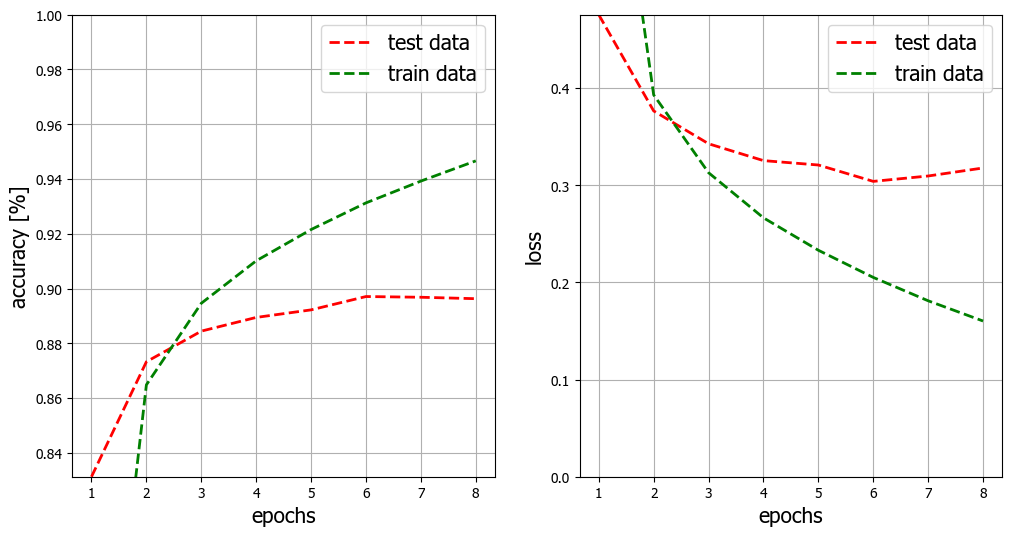

In [9]:


epochs = [ i+1 for i in range(epoch+1)]
fig, axs = plt.subplots(1,2, figsize =(12,6))
axs[0].plot(epochs,test_acc, label = 'test data' )
axs[0].plot(epochs, train_acc, label = 'train data')
axs[0].set_ylim(min(test_acc), 1)
axs[0].set_ylabel("accuracy [%]")
axs[0].legend()
axs[0].set_xlabel("epochs")
axs[0].grid()


axs[1].plot(epochs,test_loss, label = 'test data' )
axs[1].plot(epochs, train_loss, label = 'train data')
axs[1].set_ylim(0, max(test_loss))
axs[1].set_ylabel("loss")
axs[1].legend()
axs[1].set_xlabel("epochs")
axs[1].grid()

## Report 


In [10]:
from sklearn.metrics import classification_report


model.eval()
y_true=[]
y_pred=[]
with torch.no_grad():
    for inputs in test_dataloader:
        x, labels = inputs

        pred = model(x).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(labels[i].item())
            y_pred.append(pred[i].item())

print(classification_report(y_true,y_pred,digits=4, target_names = data_train.classes))

              precision    recall  f1-score   support

       World     0.9009    0.8895    0.8951      1900
      Sports     0.9555    0.9605    0.9580      1900
    Business     0.8668    0.8463    0.8565      1900
    Sci/Tech     0.8622    0.8889    0.8754      1900

    accuracy                         0.8963      7600
   macro avg     0.8963    0.8963    0.8962      7600
weighted avg     0.8963    0.8963    0.8962      7600



## Example 

original review:
 Symbol Arms Mobile Professionals With New HandheldSymbol Technologies Tuesday launched a line of enterprise-class handheld devices aimed at mobile professionals such as retail managers and supply chain management professionals.

 vectorized review:
 [15159, 3096, 472, 13480, 261, 72, 0, 2122, 1135, 1799, 21, 993, 8, 7264, 3842, 1728, 143, 472, 13480, 276, 97, 109, 1018, 25, 3155, 6741, 995]

 label
 original:Sci/Tech
 predicted:Sci/Tech


/var/folders/zf/6v5q3x1x6rxd5grqb2fp2h3h0000gn/T/ipykernel_3694/3431767863.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = torch.nn.functional.softmax(nn_output)


Text(0, 0.5, 'probability')

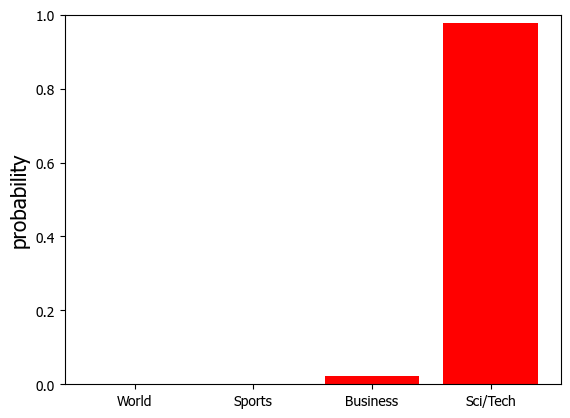

In [11]:

model.eval()
i_rand = np.random.randint(0, len(test_dataloader))

for i, inputs in enumerate(test_dataloader):
    x, labels = inputs
    y = model(x)    
    if i == i_rand:
        break 

rand_idx = np.random.randint(0, len(y))
nn_output = y[rand_idx]
probs = torch.nn.functional.softmax(nn_output)
cat_id = torch.argmax(probs)


#original data 
print("original review:\n",x_test[i*batch_size + rand_idx ])
print(f"\n vectorized review:\n", x_test_proc[i*batch_size+ rand_idx] )
label_or = data_train.classes[y_test[i*batch_size + rand_idx]-1]
label_rec = data_train.classes[cat_id]
print(f"\n label\n original:{label_or}\n predicted:{label_rec}", )

plt.bar(data_train.classes, probs.detach().numpy())
plt.ylim((0,1))
plt.ylabel("probability")





